In [1]:
from cafg import *
import datetime

# Cookbook

## Product Catalog


In [2]:
catalog = ExchangeCatalog(3)

Create a dictionary by product id

In [3]:
products = dict(map(lambda p: (p.orderbook_id, p), catalog.list()))

Find id of HSI 01/16

In [4]:
id = [x for x in catalog.list() if x.class_code.strip() == "HSI" and x.fut_opt == 'F' and x.expiration_code == '1601'][0].orderbook_id
id

751

Find ids of HSI Options 01/16

In [5]:
[x for x in catalog.list() if x.class_code.strip() == "HSI" and x.fut_opt == 'O' and x.expiration_code == '1601' and x.strike >= 23200 and x.strike <= 23400]

[(ID:840 CC:HSI    F:O EC:1601 ED:20160128, K:23400.0 CP:C PF:50),
 (ID:841 CC:HSI    F:O EC:1601 ED:20160128, K:23400.0 CP:P PF:50),
 (ID:839 CC:HSI    F:O EC:1601 ED:20160128, K:23200.0 CP:P PF:50),
 (ID:838 CC:HSI    F:O EC:1601 ED:20160128, K:23200.0 CP:C PF:50)]

Get calls expiration 01/16 with their strikes

In [6]:
[(x.strike, x.orderbook_id) for x in catalog.list() if x.class_code.strip() == "HSI" and x.fut_opt == 'O' and x.expiration_code == '1601' and x.call_put == 'C']

[(15200.0, 758),
 (21800.0, 824),
 (16800.0, 774),
 (23400.0, 840),
 (25000.0, 856),
 (18400.0, 790),
 (17000.0, 776),
 (20200.0, 808),
 (15000.0, 756),
 (26800.0, 874),
 (23600.0, 842),
 (26600.0, 872),
 (18600.0, 792),
 (25200.0, 858),
 (20000.0, 806),
 (26400.0, 870),
 (23800.0, 844),
 (22200.0, 828),
 (16400.0, 770),
 (17200.0, 778),
 (13800.0, 2715),
 (19800.0, 804),
 (21400.0, 820),
 (19000.0, 796),
 (18800.0, 794),
 (13600.0, 2713),
 (24800.0, 854),
 (19600.0, 802),
 (22000.0, 826),
 (21600.0, 822),
 (13200.0, 2709),
 (24400.0, 850),
 (27000.0, 876),
 (19400.0, 800),
 (27200.0, 878),
 (19200.0, 798),
 (24600.0, 852),
 (13400.0, 2711),
 (16600.0, 772),
 (29200.0, 898),
 (22600.0, 832),
 (21000.0, 816),
 (27600.0, 882),
 (14400.0, 2719),
 (26000.0, 866),
 (27400.0, 880),
 (24200.0, 848),
 (17600.0, 782),
 (29400.0, 900),
 (22400.0, 830),
 (15800.0, 764),
 (16200.0, 768),
 (14000.0, 752),
 (22800.0, 834),
 (29000.0, 896),
 (24000.0, 846),
 (17400.0, 780),
 (27800.0, 884),
 (21200.0

Get the id by month

In [7]:
def get_future_id(code, month, year):
    expiration = "%02d%02d" % (year % 100, month)
    return [x.orderbook_id for x in catalog.list() if x.class_code.strip() == code and x.fut_opt == 'F' and x.expiration_code == expiration][0]

get_future_id("HSI", 1, 16)

751

Convert a python date to string

In [8]:
date = datetime.date(2016, 5, 30)
print(date.strftime("%y%m%d")) # Short form
print(date.strftime("%Y%m%d")) # Long form

160530
20160530


Get current future by date. Note that if the date is after the expiration date of the current month, it returns the next contract

In [9]:
def get_future_date(code, date):
    month = date.month
    id = get_future_id("HSI", date.month, date.year)
    p = products[id]
    if p.expiration_date < date.strftime("%Y%m%d"):
        return get_future_date(code, date + datetime.timedelta(10)) # 10 days is enough to roll to the next month
    return p

print(get_future_date("HSI", datetime.date(2016, 5, 29))) # Before expiration
print(get_future_date("HSI", datetime.date(2016, 5, 30))) # Expiration day
print(get_future_date("HSI", datetime.date(2016, 5, 31))) # After expiration day

HSIK6
HSIK6
HSIM6


You can match by symbol code too

In [10]:
[x for x in catalog.list() if str(x) == "HSIF6"]

[(ID:751 CC:HSI    F:F EC:1601 ED:20160128, K:0.0 CP:  PF:50)]

Let's get the id of HSIG6. We'll use it in the next section.

In [11]:
[x for x in catalog.list() if str(x) == "HSIG6"]

[(ID:4122 CC:HSI    F:F EC:1602 ED:20160226, K:0.0 CP:  PF:50)]

## Market Data

### Subscribe to one or more products

In [12]:
def env_init():
    ts = {"capital": 1000000}

    ts["account_settings"] = AccountSettings(ts["capital"], allow_short_sell = True)
    ts["environment"] = BacktestEnvironment("20160101", ts["account_settings"])    

    ts["md"] = ts["environment"].md
    ts["exch"] = ts["environment"].exch
    ts["account"] = ts["environment"].account
    return ts
                       
ts = env_init()

def callback(quote):
    pass

def run():
    with (ts["md"].quotes.subscribe(callback)): 
        ts["md"].run("20160104", "20160105", [Product(3, 751), Product(3, 4122)]) # run takes a list of products

Always check for the quote type in the callback

In [13]:
def callback(quote):
    if quote.status == QuoteStatus.Trade:
        pass

Remember you can get help on functions and objects

In [14]:
help(QuoteStatus)

Help on class QuoteStatus in module cafg.md:

class QuoteStatus(enum.Enum)
 |  An enumeration.
 |  
 |  Method resolution order:
 |      QuoteStatus
 |      enum.Enum
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  BidAsk = <QuoteStatus.BidAsk: 2>
 |  
 |  Candlestick = <QuoteStatus.Candlestick: 3>
 |  
 |  Close = <QuoteStatus.Close: 4>
 |  
 |  Trade = <QuoteStatus.Trade: 1>
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from enum.Enum:
 |  
 |  name
 |      The name of the Enum member.
 |  
 |  value
 |      The value of the Enum member.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from enum.EnumMeta:
 |  
 |  __members__
 |      Returns a mapping of member name->value.
 |      
 |      This mapping lists all enum members, including aliases. Note that this
 |      is a read-only view of the internal mapping.



You can store the values you want in a list from inside the callback.
When working with several products, pay attention to which one is updated. This helper class combines the last update of several products by timestamp.

### Combine price of several products

In [15]:
class CombineLatest:
    def __init__(self):
        self.timestamps = []
        self.values = []
        self.v = {}
        
    def add(self, timestamp, key, value):
        if not self.has_same_timestamp(timestamp):
            if self.timestamps: 
                self.values.append(self.v)
            self.timestamps.append(timestamp)
            self.v = self.v.copy()
            
        self.v[key] = value

    def close(self):
        if self.timestamps:
            self.values.append(self.v)
        
    def has_same_timestamp(self, timestamp):
        return self.timestamps and self.timestamps[-1] == timestamp

combinator = CombineLatest()

def callback(quote):
    if quote.status == QuoteStatus.Trade:
        symbol = products[quote.code]
        combinator.add(quote.datetime, str(symbol), quote.last.px)
        
run()
combinator.close()

The Pandas/Numpy libraries have useful statistical tools. 

## Convert from lists to pandas data frame and time series

In [16]:
import pandas as pd

In [17]:
last_prices = pd.DataFrame(combinator.values, index = combinator.timestamps)
last_prices

,HSIF6,HSIG6
2016-01-04 09:14:00,21807.0,NaN
2016-01-04 09:15:00,21848.0,NaN
2016-01-04 09:15:01,21848.0,NaN
2016-01-04 09:15:02,21802.0,21778.0
2016-01-04 09:15:03,21802.0,21778.0
2016-01-04 09:15:04,21769.0,21778.0
2016-01-04 09:15:05,21769.0,21778.0
2016-01-04 09:15:06,21756.0,21778.0
2016-01-04 09:15:07,21771.0,21778.0
2016-01-04 09:15:08,21781.0,21778.0


As a Pandas time series

In [18]:
hsif6 = pd.Series(last_prices["HSIF6"])
hsif6

2016-01-04 09:14:00    21807.0
2016-01-04 09:15:00    21848.0
2016-01-04 09:15:01    21848.0
2016-01-04 09:15:02    21802.0
2016-01-04 09:15:03    21802.0
2016-01-04 09:15:04    21769.0
2016-01-04 09:15:05    21769.0
2016-01-04 09:15:06    21756.0
2016-01-04 09:15:07    21771.0
2016-01-04 09:15:08    21781.0
2016-01-04 09:15:09    21763.0
2016-01-04 09:15:10    21770.0
2016-01-04 09:15:11    21792.0
2016-01-04 09:15:12    21785.0
2016-01-04 09:15:13    21783.0
2016-01-04 09:15:14    21790.0
2016-01-04 09:15:15    21797.0
2016-01-04 09:15:16    21795.0
2016-01-04 09:15:17    21788.0
2016-01-04 09:15:18    21790.0
2016-01-04 09:15:19    21791.0
2016-01-04 09:15:20    21786.0
2016-01-04 09:15:21    21787.0
2016-01-04 09:15:22    21782.0
2016-01-04 09:15:23    21791.0
2016-01-04 09:15:24    21789.0
2016-01-04 09:15:25    21790.0
2016-01-04 09:15:26    21783.0
2016-01-04 09:15:27    21786.0
2016-01-04 09:15:28    21783.0
                        ...   
2016-01-04 16:14:30    21132.0
2016-01-

Use pandas to analyze a time series. For example, resample in periods of 5 seconds using the mean.

In [19]:
hsif6.resample("5T").mean()

2016-01-04 09:10:00    21807.000000
2016-01-04 09:15:00    21752.602888
2016-01-04 09:20:00    21653.485915
2016-01-04 09:25:00    21651.463415
2016-01-04 09:30:00    21654.321799
2016-01-04 09:35:00    21606.401361
2016-01-04 09:40:00    21583.053571
2016-01-04 09:45:00    21544.182759
2016-01-04 09:50:00    21488.742373
2016-01-04 09:55:00    21479.407666
2016-01-04 10:00:00    21452.041522
2016-01-04 10:05:00    21420.681661
2016-01-04 10:10:00    21399.581882
2016-01-04 10:15:00    21404.844523
2016-01-04 10:20:00    21428.239583
2016-01-04 10:25:00    21405.896679
2016-01-04 10:30:00    21404.191406
2016-01-04 10:35:00    21401.908745
2016-01-04 10:40:00    21403.153153
2016-01-04 10:45:00    21402.145749
2016-01-04 10:50:00    21405.151042
2016-01-04 10:55:00    21403.128889
2016-01-04 11:00:00    21368.210909
2016-01-04 11:05:00    21365.767176
2016-01-04 11:10:00    21341.070632
2016-01-04 11:15:00    21315.940959
2016-01-04 11:20:00    21337.806202
2016-01-04 11:25:00    21342

Or calculate the standard deviation

In [20]:
hsif6.std()

127.44979631718289

SciPy has many other useful functions.

## Exchange Simulator

### Place an order

This is the simplest form. It puts the trade in a single portfolio and timestamps the trade with the current simulation time.

> Note: the order_id must be unique. Orders using a previous order id will be rejected.

In [21]:
side = Side.Buy
q = 1
exchange_id = 3
product_id = 751

order_id = 10

order = Order(0, order_id, TimeInForce.ImmediateOrCancel, OrderType.Market, exchange_id, product_id, 
                              side, 0.0, q, "", 0, 0)

For the competition, use only this type of order. It fills as much as possible and cancels the remaining part (if any).

Cancelling and changing orders are not allowed.

### Getting execution reports

Just like one can subscribe to market data events, the exchange simulator publishes execution reports.

In [22]:
def ex_cb(execution): 
    print(execution)

with ts["exch"].executions.subscribe(ex_cb):
    ts["exch"].new_order(0, order)

(TS:1451897648000000000 OID:10 ID:2 CODE:751 OS:OrderStatus.Filled SIDE:Side.Buy CQ:1 EQ:1 EP:21170 RS:)


They aren't as important as market data events because the account keeps track of executions internally and updates the position automatically.

## Account

### Get a list of trades

Notable fields of an execution are the executed price and quantity

In [23]:
ts["account"].get_trades()

[(TS:1451897648000000000 OID:10 ID:2 CODE:751 OS:OrderStatus.Filled SIDE:Side.Buy CQ:1 EQ:1 EP:21170 RS:)]

Get account performance

In [24]:
ts["account"].get_stats()

,day_end_capital,day_end_exposure,day_end_value,day_pnl,day_start_capital,day_start_value,max_drawdown,max_long,max_profit,max_short,realized_pnl
timestamp,,,,,,,,,,,
2016-01-04,1000000.0,0.0,0.0,0.0,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0


## Plots and Graphs

Numpy and Pandas are integrated with Matplotlib. Use the following command to include a plot in the current notebook

In [25]:
%matplotlib inline

Plotting a data frame or a time series. Note that there is interpolation line between 12:00 and 13:00 because of the lack of data during the lunch break. The same thing happens during nights and week ends. Unfortunately, matplotlib can't skip these time frames

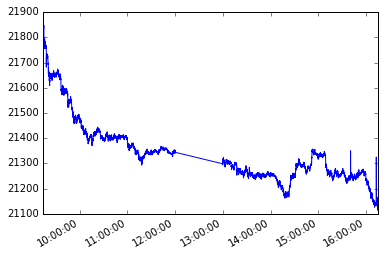

In [26]:
hsif6.plot()

Use highcharts for financial data. Data must be given as an array of [X Y].

In [27]:
import numpy as np

The first line converts the time index to epoch time. The second line zips the time index and the data into an list of lists. Pandas and Numpy use optimized data storage for arrays and matrices therefore we have to go through this step to get it readable by Highcharts

In [28]:
timestamps = hsif6.index.astype(np.int64) // 1000000
plot_data = np.dstack((timestamps, hsif6.values))[0].tolist()

In [29]:
from highcharts import Highstock

In [30]:
H = Highstock()

options = {
    'rangeSelector' : {
            'selected' : 1
    },
    'title' : {
        'text' : 'HSIF6'
    }
}
H.set_dict_options(options)
H.add_data_set(plot_data, 'spline', 'Last Price', marker={'enabled': False}) 

H

The chart skips over lunch breaks, nights and week ends and can be zoomed in/out

### Plotting several series on the same graph

You can add another data series to the graph

In [31]:
options["title"]["text"] = "HSIF6/HSIG6"
H.set_dict_options(options)

hsig6 = pd.Series(last_prices["HSIG6"])
plot_data2 = np.dstack((timestamps, hsig6.values))[0].tolist()
H.add_data_set(plot_data2, 'spline', 'Last Price', marker={'enabled': False}, id="HSIG6")

In [32]:
H

## Event flags

You can add a data series that marks important moments. For instance, to add flags for the lunch break and the mid day:

In [33]:
flags = [{
        'x' : datetime.datetime(2016, 1, 4, 12, 0, 0),
        'title' : 'A',
        'text' : 'Lunch Break'
    }, {
        'x' : datetime.datetime(2016, 1, 4, 15, 0, 0),
        'title' : 'B',
        'text' : 'Mid day'
    }]

H.add_data_set(flags, 'flags', onSeries = 'HSIG6',
                shape = 'circlepin',
                width = 16)
H

> Markers can be used to indicate signals and trades